# Práctica 4. Interpolación: Funciones Spline

**Autor:** Arturo Olivares Martos
***

- **Asignatura:** Métodos Numéricos I.
- **Curso Académico:** 2022-23.
- **Grado:** Doble Grado en Ingeniería Informática y Matemáticas.
- **Grupo:** Único.
- **Profesor:** Miguel Ángel Piñar González.
- **Descripción:** Práctica 4 de la asignatura Métodos Numéricos I. Uso de funciones spline para la interpolación de funciones.
<!--- **Fecha:** 17 de abril de 2023. -->
<!-- - **Duración:** -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Se desea construir un gráfico en el que se incluyan la función interpolada
$$f(x)=\frac{1}{1+x^2}$$
y las gráficas de dos splines cúbicos naturales que interpolan a $f$ en, respectivamente, $11$ y $21$ puntos equiespaciados del intervalo $[-5, 5]$.

## Ejercicio 1
Construya un array que contenga un conjunto de $n$ puntos equiespaciados del intervalo $[−5, 5]$.

El algoritmo se ha realizado de forma escalable, de forma que si se desea modificar el dominio, basta con cambiar el array DOMINIO.

In [3]:
######################################
DOMINIO = np.array([-5, 5])
######################################

def px(n):
    return np.linspace(DOMINIO[0], DOMINIO[1], n)

## Ejercicio 2
Construya un array que contenga las imágenes mediante $f(x)=\frac{1}{1+x^2}$ de los puntos anteriores.

El algoritmo se ha realizado de forma escalable, de forma que si se desea la función a interpolar, basta con cambiar la definición de f.

In [2]:
def f(x):
    return 1/(1+x**2)

## Ejercicio 3
Construya una función en Python que a partir de los arrays anteriores  debe construir una función spline que obtenga la lista de derivadas que definen el spline cúbico natural, usando el sistema tridiagonal de ecuaciones.

In [4]:
def spline(lista_x, lista_f):
    
    # Los puntos son x_0, ..., x_n
    n=len(lista_x)-1
    
    # Calculo los valores de h y de delta
    h = np.zeros(n)
    delta = np.zeros(n)
    
    for i in range(0, n):
        h[i]=lista_x[i+1]-lista_x[i]
        delta[i] = (lista_f[i+1]-lista_f[i]) / h[i]
        
    # Obtengo la matriz de coeficientes y de términos independientes
    A = np.zeros((n+1,n+1))
    B = np.zeros(n+1)
    
    # Obtengo en primer lugar la fila 0 y la fila n, ya que son distintas
    A[0][0] = 2/h[0]
    A[0][1] = 1/h[0]
    B[0] = delta[0]/h[0]
    
    A[n][n-1] = 1/h[n-1]
    A[n][n] = 2/h[n-1]
    B[n] = delta[n-1]/h[n-1]
    
    # Obtengo el resto de filas, iterando sobre cada fila
    for i in range(1, n):
        A[i][i-1] = 1/h[i-1]
        A[i][i+1] = 1/h[i]
        A[i][i]   = 2*(A[i][i-1] + A[i][i+1])
        
        B[i] = delta[i]/h[i] + delta[i-1]/h[i-1]
    
    B=3*B
    
    
    # Resuelvo el sistema para obtener el valor de las derivadas
    lista_d = np.linalg.solve(A, B)
    
    return(lista_d)

## Ejercicio 4

Para dibujar la lista de polinomios que constituyen el spline construya su propia función evalspline que dados los puntos de interpolación, sus imágenes, la lista de derivadas devuelta por la función spline, y un punto $x$ arbitrario del intervalo $[-5,5]$ proporcione el valor del spline en el punto $x$.

Para ello, primero deberá localizar el intervalo en que se encuentra $x$ y después deberá evaluar en $x$ el polinomio de grado 3 que define el spline en dicho intervalo.

In [5]:
def calc_dif_div_Hermite (lista_x, lista_f, lista_d):
    n = len(lista_x)
    
    dif_divididas = np.zeros([n,n])
    """
    Definimos dif_divididas[i][k] como f[x_i, ..., x_{i+k}]
    """
    
    # La tabla se va completando por columnas
    
    # En primer lugar, completo las diferencias divididas de solo un término. (columna 0)
    for i in range(n):
        dif_divididas[i][0]=lista_f[i]
    
    # Para las de más de un término, itero sobre k, la diferencia entre el último y el primero de la diferencia dividida.
    # También se puede entender k=nº de términos de la diferencia dividida -1
    # También se puede entender k=nº de términos de la diferencia dividida empezando desde 0
    # En cada iteración se rellena la columna k, al igual que al representarla nosotros a mano
    for k in range(1,n):
        for i in range(0, n-k):
            
            if (lista_x[i+k] == lista_x[i]):
                # Como se pasan las abcisas duplicadas, se divide entre 2
                dif_divididas[i][k] = lista_d[int(i/2)]
            
            else:
                dif_divididas[i][k] = (dif_divididas[i+1][k-1] - dif_divididas[i][k-1]) / (lista_x[i+k] -lista_x[i])
    
    # Los coeficientes son f[0, k], para todo k. Por tanto, nos quedamos con la primera fila.
    return dif_divididas[0]

In [6]:
def NewtonHorner (x, puntos_x, coeficientes):
    valor = 0
    
    n = len(coeficientes)
    
    # Itero desde el final hasta el principio, ya que voy desde dentro hacia afuera.
    for i in range (n-1, 0-1, -1):
        valor = valor*(x-puntos_x[i]) + coeficientes[i]
    
    return valor

In [7]:
def evalspline(lista_x, lista_f, lista_d, t):
    
    #Busco el intervalo en el que se ecuentra, sabiendo que la lista_x está ordenada
    i = 0
    
    while (t>lista_x[i]):
        i+=1
    
    # Sabemos que t € [x_{i-1}, x_1]. Interpolamos con las abscisas repetidas. Como los polinomios son de grado 3 (cúbicos),
    # requieren de 4 puntos
    x_inter = np.array([lista_x[i-1], lista_x[i-1], lista_x[i], lista_x[i]])
    f_inter = np.array([lista_f[i-1], lista_f[i-1], lista_f[i], lista_f[i]])
    
    d_inter = np.array([lista_d[i-1], lista_d[i]])
    
    coef_Newton = calc_dif_div_Hermite (x_inter, f_inter, d_inter)
    
    return NewtonHorner(t, x_inter, coef_Newton)

## Ejercicio 5
Realizar la gráfica pedida.

El algoritmo se ha realizado de forma escalable, de forma que si se desea cambiar los grados de los polinomios de interpolación, basta con cambiar el array GRADOS.

In [8]:
# Número de puntos para que parezcan curvas y no unión de segmentos.
npuntos = 1000;
px_f = px(npuntos)

# Gráfica real de la curva de Agnesí
py_f = f(px_f)

######################################
# Número de nodos a interpolar
N_NODOS = np.array([3, 5, 7, 11,21])
######################################

# Cada fila de la matriz contendrá las imágenes de los N_NODOS mediante el polinomio de interpolacion
py_nNodos = np.zeros([len(N_NODOS), npuntos])

# Calculo y evalúo el polinomio para cada uno de los splines de N_NODOS
for i in range(len(N_NODOS)):
    
    # Para cada número de puntos, calculo los datos "previos"
    px_interpolacion_i_nodos = px(N_NODOS[i])
    py_interpolacion_i_nodos = f(px_interpolacion_i_nodos)
    
    # Obtengo ahora las derivadas
    lista_d = spline(px_interpolacion_i_nodos, py_interpolacion_i_nodos)
            
    # Evalúo el spline
    for j in range(len(px_f)):
        py_nNodos[i][j] = evalspline(px_interpolacion_i_nodos, py_interpolacion_i_nodos, lista_d, px_f[j])

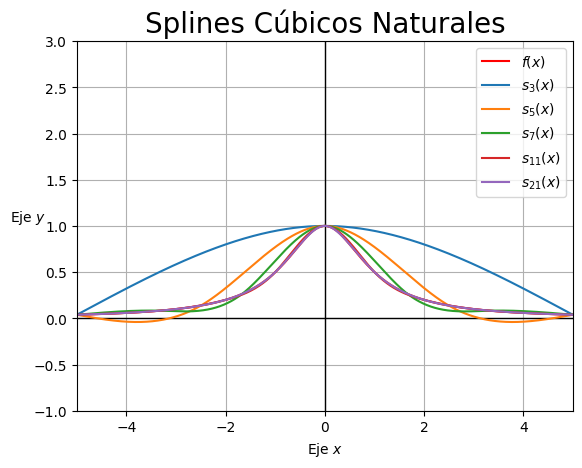

In [9]:
# Represento los ejes
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)
plt.xlabel('Eje $x$')
plt.ylabel('Eje $y$', rotation=0)

# Represento la función
plt.plot(px_f,py_f, 'r', label='$f(x)$')

plt.ylim(-1, 3)
plt.xlim(-5,5)


# Represento cada grado
for i in range(len(N_NODOS)):
    plt.plot(px_f,py_nNodos[i], label='$s_{'+str(N_NODOS[i])+'}(x)$')
 

plt.grid()
plt.title("Splines Cúbicos Naturales", fontsize=20)
plt.legend()
plt.show()
#plt.savefig('grafico.svg')

Como vemos, con el uso de splines se elimina el fenómeno de Runge, que se produce en la interpolación de polinomios de grado alto.